## Data Summary

- 82 patients in total
- 36 patients with intracranial hemorrhage
- 46 normal patients
- Approx. 30 CT slices for each patient (e.g. 34 for patient 58)
- 46 males
- 36 females

- 318 of 2500 images have masks that show intracranial hemorrhage

- Images: 650x650x1
- Masks: 650x650x1

- Two kinds of windowed images are available - brain window and bone window


## Approach

- We will only use the brain window images. We will convert these to 3 channel images to suit the model.
- Apply DWT
- Resize images and masks to 256x256
- Set aside 20 images as a holdout test set.
- Split the remainder of the data into 85% train and 15% validation.
- Use a Keras Densenet121 encoder with a Unet decoder - Adam optimizer and dice loss.
- We won't use Densenet pre-procesing. Instead we will simply normalize the images by dividing by 255.
- The dataset is quite small therefore, we will use data augmentation to reduce overfitting and to help the model generalize better.

In [1]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from skimage.io import imread, imshow
from skimage.transform import resize


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

IMAGE_HEIGHT_ORIG = 650
IMAGE_WIDTH_ORIG = 650

NUM_TEST_IMAGES = 10 
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3

BATCH_SIZE = 10


In [3]:
base_path = 'CTBRAIN/'
os.listdir(base_path)
# This is how to access the downloaded folders


['.DS_Store',
 'patient_demographics.csv',
 'hemorrhage_diagnosis.csv',
 'Patients_CT',
 'ct_ich.yml',
 'README.txt',
 'LICENSE.txt',
 'split_data.py',
 'SHA256SUMS.txt']

In [4]:
# Function to perform the augmentations

def augment_image_and_mask(augmentation, image, mask):
    
    """
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    3. mask - mask with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    Augmented mask as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image, mask=mask)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    mask_matrix = aug_image_dict['mask']
    
    return image_matrix, mask_matrix


## Download Packages

We will use the excellent segmentation_models package by Pavel Yakubovskiy <br>
https://github.com/qubvel/segmentation_models

More info can be found here:<br>
https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/103367

## Prepare the data

In [5]:
path = base_path + 'hemorrhage_diagnosis.csv'
df_diag = pd.read_csv(path)

# The existing No_Hemorrhage target column is not intuitive. 
# Create a new target column to make the binary targets easier to understand.

def swap_target(x):
    if x == 0:
        return 1
    else:
        return 0

# create a new target column
df_diag['Has_Hemorrhage'] = df_diag['No_Hemorrhage'].apply(swap_target)

# drop the old target column
df_diag = df_diag.drop('No_Hemorrhage', axis=1)

print(df_diag.shape)

df_diag.head()

(2501, 9)


,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage
0,49,1,0,0,0,0,0,0,0
1,49,2,0,0,0,0,0,0,0
2,49,3,0,0,0,0,0,0,0
3,49,4,0,0,0,0,0,0,0
4,49,5,0,0,0,0,0,0,0


In [6]:
# Patient 84
# Brain image 36.jpg exists but bone image 36.jpg is missing.

# Therefore, we will drop this row from the dataframe.

index_to_drop = df_diag[(df_diag['PatientNumber'] == 84) & (df_diag['SliceNumber'] == 36)].index

index_to_drop = index_to_drop[0]

df_diag = df_diag.drop(index_to_drop, axis=0)


# Check that the row that we dropped has been removed
df_diag[df_diag.index == index_to_drop]

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage


### Creat new columns

Here we will be creating new image and mask file names to make the data easier to handle later. These new names will be added as new columns in df_diag.

In [7]:
# Create new columns


def get_mask_fname(row):
        
    mask_id = str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id
    

# create a new column with mask file names
df_diag['mask_fname'] = df_diag.apply(get_mask_fname, axis=1)




def new_mask_fname(row):
        
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id


# create a new column with a new mask file names
df_diag['new_mask_fname'] = df_diag.apply(new_mask_fname, axis=1)




def assign_image_fname(row):
    
    image_fname = str(row['SliceNumber']) + '.jpg'
    
    return image_fname


# create a new column with image file names
df_diag['image_fname'] = df_diag.apply(assign_image_fname, axis=1)



def assign_new_fname(row):
         
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '.jpg'
    
    return mask_id
    
# create a new column with new image file names
df_diag['new_image_fname'] = df_diag.apply(assign_new_fname, axis=1)



df_diag.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage,mask_fname,new_mask_fname,image_fname,new_image_fname
0,49,1,0,0,0,0,0,0,0,1_HGE_Seg.jpg,49_1_HGE_Seg.jpg,1.jpg,49_1.jpg
1,49,2,0,0,0,0,0,0,0,2_HGE_Seg.jpg,49_2_HGE_Seg.jpg,2.jpg,49_2.jpg
2,49,3,0,0,0,0,0,0,0,3_HGE_Seg.jpg,49_3_HGE_Seg.jpg,3.jpg,49_3.jpg
3,49,4,0,0,0,0,0,0,0,4_HGE_Seg.jpg,49_4_HGE_Seg.jpg,4.jpg,49_4.jpg
4,49,5,0,0,0,0,0,0,0,5_HGE_Seg.jpg,49_5_HGE_Seg.jpg,5.jpg,49_5.jpg


In [8]:
# This is the binary target distribution.
# You will note that it is unbalanced - most images have no signs of hemorrhage.

df_diag['Has_Hemorrhage'].value_counts()

0    2182
1     318
Name: Has_Hemorrhage, dtype: int64

In [9]:
# This is the total number of patients

df_diag['PatientNumber'].nunique()

82

### Move all masks into the same folder

In [10]:
path = base_path +'Patients_CT'

folder_list = os.listdir(path)

len(folder_list)

83

In [11]:
# create a new mask dir
mask_dir = 'mask_dir'
os.mkdir(mask_dir)

In [12]:
for folder_name in folder_list:
    
    # convert the folder name to integer
    print(folder_name)

104
103
102
105
.DS_Store
079
077
083
084
070
071
085
049
082
076
078
065
091
096
062
054
053
098
052
099
055
063
097
090
064
129
116
111
118
127
120
121
119
126
110
128
117
109
100
107
106
101
108
130
089
087
073
074
080
081
075
072
086
088
095
061
066
092
059
050
057
068
056
069
051
093
067
058
060
094
112
115
123
124
125
122
114
113


In [13]:
import re
list1=[]
for folder_name in folder_list:
    numbers = re.findall(r'\d+', folder_name)
    list1.append(numbers)
import itertools
flat_list = list(itertools.chain(*list1))
print(flat_list)

int_list = []

for string in flat_list:
    integer = int(string)
    int_list.append(integer)

print(int_list)
    

['104', '103', '102', '105', '079', '077', '083', '084', '070', '071', '085', '049', '082', '076', '078', '065', '091', '096', '062', '054', '053', '098', '052', '099', '055', '063', '097', '090', '064', '129', '116', '111', '118', '127', '120', '121', '119', '126', '110', '128', '117', '109', '100', '107', '106', '101', '108', '130', '089', '087', '073', '074', '080', '081', '075', '072', '086', '088', '095', '061', '066', '092', '059', '050', '057', '068', '056', '069', '051', '093', '067', '058', '060', '094', '112', '115', '123', '124', '125', '122', '114', '113']
[104, 103, 102, 105, 79, 77, 83, 84, 70, 71, 85, 49, 82, 76, 78, 65, 91, 96, 62, 54, 53, 98, 52, 99, 55, 63, 97, 90, 64, 129, 116, 111, 118, 127, 120, 121, 119, 126, 110, 128, 117, 109, 100, 107, 106, 101, 108, 130, 89, 87, 73, 74, 80, 81, 75, 72, 86, 88, 95, 61, 66, 92, 59, 50, 57, 68, 56, 69, 51, 93, 67, 58, 60, 94, 112, 115, 123, 124, 125, 122, 114, 113]


In [14]:
# For non blank masks i.e. masks showing intracranial hemorrhage

for folder_name in flat_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    # filter by Has_Hemorrhage
    df = df[df['Has_Hemorrhage'] == 1]
    
    # get the list of mask file names
    mask_list = list(df['mask_fname'])
    
    for fname in mask_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # Source path to mask.
        # All masks are in the brain folder.
        path = base_path + 'Patients_CT/' + folder_name + '/brain'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(mask_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
# Check how many masks are in the new folder. (Should be 318)
len(os.listdir('mask_dir'))

318

In [15]:
# For blank masks i.e. masks without intracranial hemorrhage

blank_mask = np.zeros((IMAGE_HEIGHT_ORIG, IMAGE_WIDTH_ORIG))


for folder_name in flat_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    # filter by Has_Hemorrhage
    df = df[df['Has_Hemorrhage'] == 0]  # <-- for empty masks change filter here
    
    # get the list of mask file names
    mask_list = list(df['mask_fname'])
    
    for fname in mask_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # set the destination where the file will be saved
        dst = os.path.join(mask_dir, new_fname)
      
        # save the image
        cv2.imwrite(dst, blank_mask)
        
# Check how many masks are in the new folder. (Should be 2500)
len(os.listdir('mask_dir'))



2500

### Move all brain window images into the same folder

In [16]:
# create a new mask dir
brain_image_dir = 'brain_image_dir'
os.mkdir(brain_image_dir)

In [17]:
for folder_name in flat_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    
    # get the list of image file names
    image_list = list(df['image_fname'])
    
    for fname in image_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # source path to image
        path = base_path + 'Patients_CT/' + folder_name + '/brain'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(brain_image_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
        

# Check how many images are in the new folder (Should be 2500)
len(os.listdir('brain_image_dir'))

2500

### Move all bone window images into the same folder

In [18]:
# create a new mask dir
bone_image_dir = 'bone_image_dir'
os.mkdir(bone_image_dir)

In [19]:
for folder_name in flat_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    
    # get the list of image file names
    image_list = list(df['image_fname'])
    
    for fname in image_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # source path to image
        path = base_path + 'Patients_CT/' + folder_name + '/bone'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(bone_image_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
        
# Check how many images are in the new folder (Should be 2500)
len(os.listdir('bone_image_dir'))

2500

## Display Images and Masks

(650, 650)


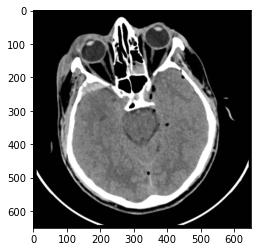

In [20]:
# brain image

index = 14
fname = df_diag.loc[index, 'new_image_fname']
path = 'brain_image_dir/' + fname
# read the image as a matrix
brain_image = plt.imread(path)

print(brain_image.shape)

plt.imshow(brain_image, cmap='gray')

(650, 650)


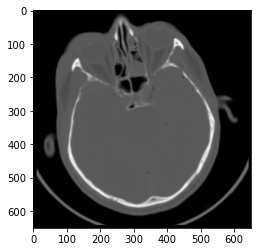

In [21]:
# bone image

fname = df_diag.loc[index, 'new_image_fname']
path = 'bone_image_dir/' + fname
# read the image as a matrix
bone_image = plt.imread(path)

print(bone_image.shape)

plt.imshow(bone_image, cmap='gray')

(650, 650)


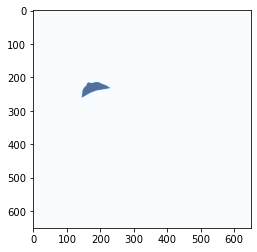

In [22]:
# mask

fname = df_diag.loc[index, 'new_mask_fname']
path = 'mask_dir/' + fname
# read the image as a matrix
mask = plt.imread(path)

print(mask.shape)

plt.imshow(mask, cmap='Blues', alpha=0.7)

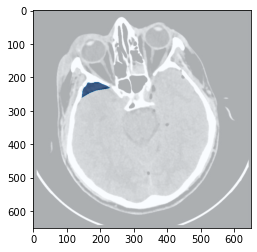

In [23]:
plt.imshow(brain_image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.7)

## Set up data augmentation

In [24]:
!pip install albumentations

In [25]:
# HOW TO DO MULTIPLE AUGMENTATIONS

import albumentations as albu

# Define the augmentations

aug_types = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.OneOf([
        albu.RandomContrast(),
        albu.RandomGamma(),
        albu.RandomBrightness(),
        ], p=0.3),
    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=0),
])


# This how to call the function
# aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)

/Users/aashisrout/opt/anaconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/Users/aashisrout/opt/anaconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


(650, 650, 3)


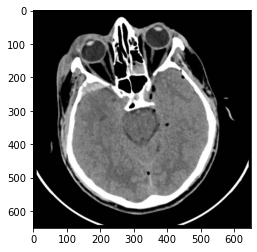

In [26]:
# brain image

index = 14
fname = df_diag.loc[index, 'new_image_fname']
path = 'brain_image_dir/' + fname
# read the image as a matrix
brain_image = cv2.imread(path)

print(brain_image.shape)

plt.imshow(brain_image, cmap='gray')

(650, 650)


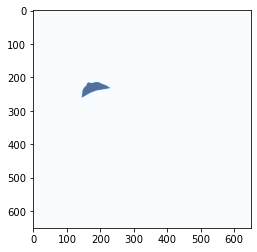

In [27]:
# mask

fname = df_diag.loc[index, 'new_mask_fname']
path = 'mask_dir/' + fname
# read the image as a matrix
mask = plt.imread(path)

print(mask.shape)

plt.imshow(mask, cmap='Blues', alpha=0.7)

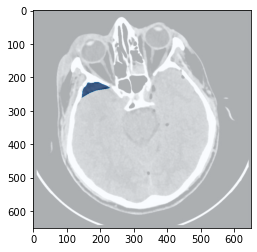

In [28]:
plt.imshow(brain_image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.7)

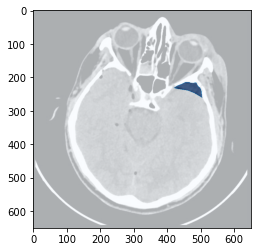

In [29]:
# Example augmentation - image and mask

# augment the image and mask
aug_image, aug_mask = augment_image_and_mask(aug_types, brain_image, mask)



plt.imshow(aug_image, cmap='gray')
plt.imshow(aug_mask, cmap='Blues', alpha=0.7)

### Display a ramdom sample of images from each dataset by target

In [30]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['new_image_fname']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)
               
    plt.tight_layout()
    plt.show()
    
   
  
  
def draw_category_masks(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['new_mask_fname']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

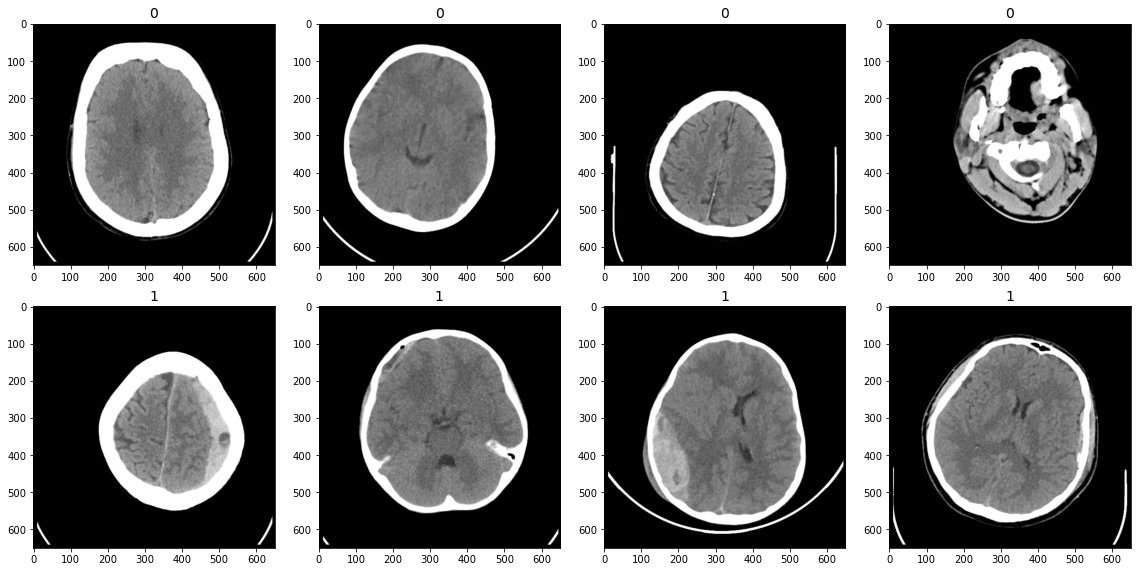

In [31]:
# Brain images

IMAGE_PATH = 'brain_image_dir/'
draw_category_images('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

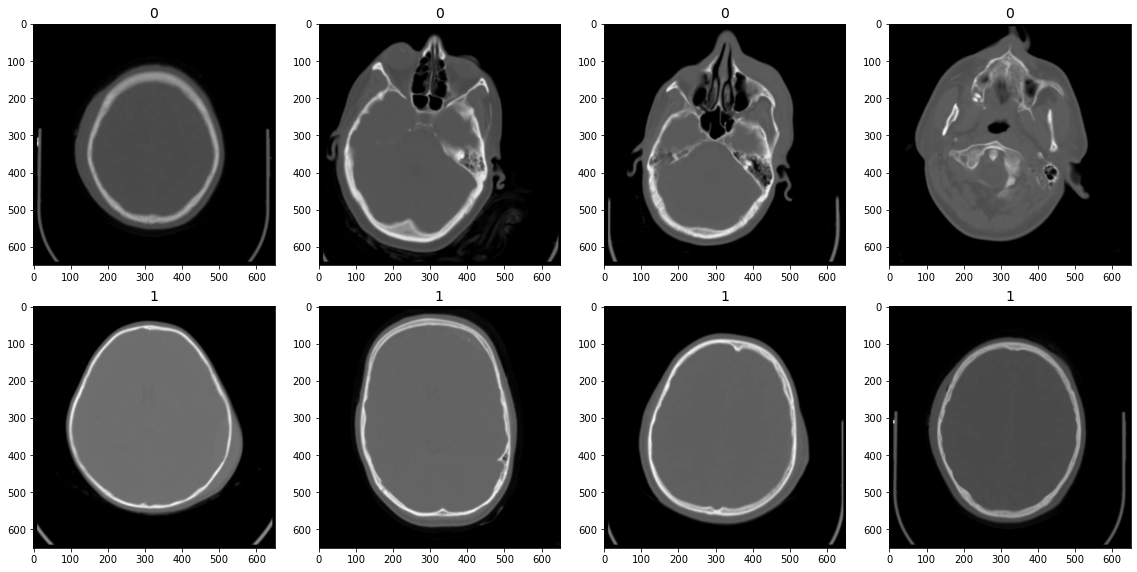

In [32]:
# Bone images

IMAGE_PATH = 'bone_image_dir/'

draw_category_images('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

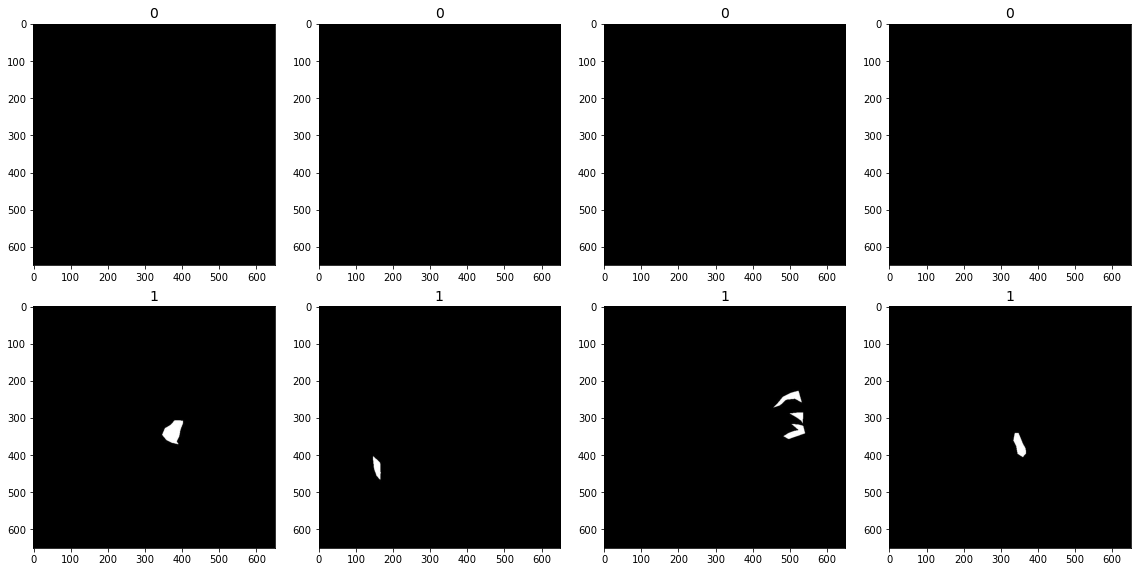

In [33]:
# Masks

IMAGE_PATH = 'mask_dir/'

draw_category_masks('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

## Create a holdout test set

This will be set aside and won't be used during training and validation. We will use it later to check how the trained model performs on unseen data.

In [34]:
NUM_TEST_IMAGES = 10


# get 10 images without hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 0]

df_no_hem = df.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
df_no_hem = df_no_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_no_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# get 10 images with hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 1]

df_with_hem = df.sample(NUM_TEST_IMAGES, random_state=102)

# Reset the index.
df_with_hem = df_with_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_with_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# create the test set
df_test = pd.concat([df_with_hem, df_no_hem], axis=0).reset_index(drop=True)



print(df_diag.shape)
print(df_test.shape)

(2480, 13)
(20, 13)


In [35]:
df_test.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage,mask_fname,new_mask_fname,image_fname,new_image_fname
0,49,20,0,0,0,1,0,1,1,20_HGE_Seg.jpg,49_20_HGE_Seg.jpg,20.jpg,49_20.jpg
1,50,26,0,1,0,0,0,1,1,26_HGE_Seg.jpg,50_26_HGE_Seg.jpg,26.jpg,50_26.jpg
2,81,16,0,0,0,0,1,0,1,16_HGE_Seg.jpg,81_16_HGE_Seg.jpg,16.jpg,81_16.jpg
3,49,27,0,1,0,0,0,1,1,27_HGE_Seg.jpg,49_27_HGE_Seg.jpg,27.jpg,49_27.jpg
4,70,13,0,0,0,1,0,0,1,13_HGE_Seg.jpg,70_13_HGE_Seg.jpg,13.jpg,70_13.jpg


## Train Test Split

In [36]:
# train_test_split


# shuffle
df_diag = shuffle(df_diag)

# reset the index
df_diag = df_diag.reset_index(drop=True)

# We will stratify by target
y = df_diag['Has_Hemorrhage']

df_train, df_val = train_test_split(df_diag, test_size=0.15, random_state=107, stratify=y)

print(df_train.shape)
print(df_val.shape)

(2108, 13)
(372, 13)


In [37]:
# Check the target distribution in the train set

df_train['Has_Hemorrhage'].value_counts()

0    1846
1     262
Name: Has_Hemorrhage, dtype: int64

In [38]:
# Check the target distribution in the val set

df_val['Has_Hemorrhage'].value_counts()

0    326
1     46
Name: Has_Hemorrhage, dtype: int64

## Save the dataframes as compressed csv files

These csv files will allow us to use Pandas chunking to feed images into the generators.

In [39]:
df_diag.to_csv('df_data.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)


In [40]:
# check if the files were saved
!ls

CTBRAIN                                df_train.csv.gz
bone_image_dir                         df_val.csv.gz
brain_image_dir                        intracranial-hemorrhage-analyzer.ipynb
df_data.csv.gz                         mask_dir
df_test.csv.gz


In [41]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


## Build the Data Generators

In [42]:
!pip install tensorflow

In [43]:
# Note:
# We won't be using densenet101 pre-processing however,
# this code would need to be run if we were going to use it in the generators.

from segmentation_models import  get_preprocessing # this line has an error in the docs

BACKBONE = 'densenet121'
preprocess_input = get_preprocessing(BACKBONE)

2023-05-05 12:23:30.244802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


### [ 1 ] Train Generator

In [44]:
# We are only using brain images for training.
# These are originally single channel images but cv2 will read them with 3 channels.

def train_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]
                mask_id = mask_id_list[i]
              
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create Y_train
            # ===============
                
 

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
         
                
                
              
              
              
            # Augment the image and mask
            # ===========================
            
                aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)
              
                # insert the image into X_train
                X_train[i] = aug_image
                
                # insert the image into Y_train
                Y_train[i] = aug_mask
                
                              
                
            # Normalize the images
            X_train = X_train/255

            yield X_train, Y_train

In [45]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=10)

# run the generator
X_train, Y_train = next(train_gen)

print(X_train.shape)
print(Y_train.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


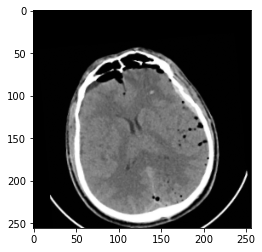

In [46]:
# print the first image in X_train

img = X_train[7,:,:,:]
plt.imshow(img)

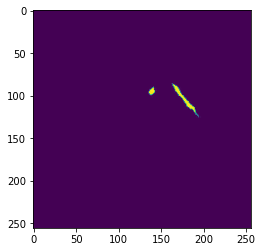

In [47]:
# print the mask in Y_train

msk = Y_train[7,:,:,0]
plt.imshow(msk)

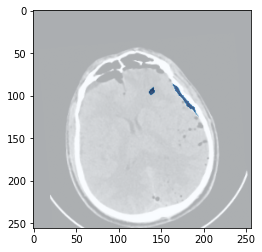

In [48]:
plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.7)

### [ 2 ] Val Generator

In [49]:
def val_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

        
            
            # Create X_val
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_val[i] = image
            
            
            # Create Y_val
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_val[j] = mask
                
            
            # Normalize the images
            X_val = X_val/255
            
            yield X_val, Y_val

In [50]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=10)

# run the generator
X_val, Y_val = next(val_gen)

print(X_val.shape)
print(Y_val.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


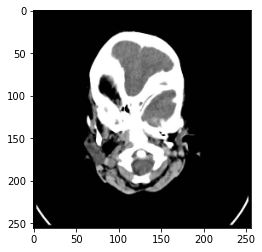

In [51]:
# print the image from X_val

img = X_val[7,:,:,:]
plt.imshow(img)

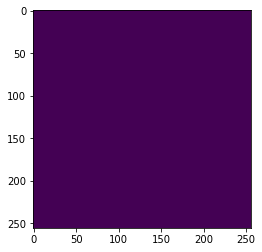

In [52]:
# print the mask from Y_val

msk = Y_val[7,:,:,0]
plt.imshow(msk)

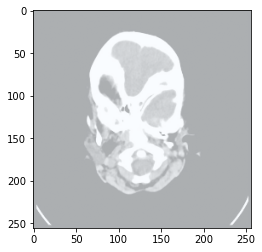

In [53]:
# Combine the mask and the image

plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.7)

### [ 3 ] Test Generator

In this test generator we will output both the test images (X_test) and the test masks (Y_test). 

In [54]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_test.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)
            


            
            # Create X_test
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
           
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_test[i] = image
                
             
            # Create Y_test
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_test[j] = mask
            
            
            # Normalize the images
            X_test = X_test/255
            
            yield X_test, Y_test


In [55]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=15)

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

(15, 256, 256, 3)
(15, 256, 256, 1)


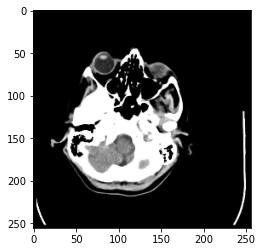

In [56]:
# print the image from X_test

img = X_test[14,:,:,:]
plt.imshow(img)

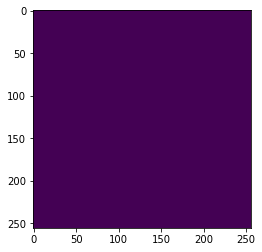

In [57]:
# print the mask from Y_test

msk = Y_test[14,:,:,0]
plt.imshow(msk)

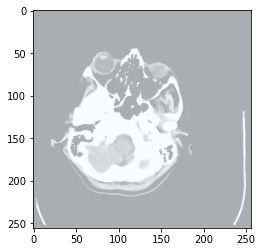

In [58]:
# Combine the mask and the image

plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.7)

## Model Architecture

In [59]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)


from keras.optimizers import Adam
from keras.losses import binary_crossentropy

from keras.initializers import he_normal 

import tensorflow as tf

In [60]:
from segmentation_models import Unet, FPN
from segmentation_models import  get_preprocessing# this line has an error in the docs



from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from segmentation_models.losses import dice_loss


from segmentation_models.utils import set_trainable

In [61]:
#preprocess = get_preprocessing('resnet101') # for resnet, img = (img-110.0)/1.0

BACKBONE = 'densenet121'
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
model = Unet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
             #freeze_encoder=False,
             classes=1, 
             encoder_weights='imagenet',
             activation='sigmoid')

#model.summary()

## Create X_test
Here we will use the test generator with a batch size of len(df_test) to create X_test and Y_test. Because the batch size is equal to the number of rows in df_test, the generator will ouput the entire
test set (100 rows) as a matrix.

In [62]:
# initialize
test_gen = test_generator(batch_size=len(df_test))

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

(20, 256, 256, 3)
(20, 256, 256, 1)


## Train the Model

In [63]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [64]:
# Initialize the generators
train_gen = train_generator(batch_size=10)
val_gen = val_generator(batch_size=10)

model.compile(
    optimizer="adam",
    loss=dice_loss,
    metrics=[iou_score],
)



filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, earlystopper] #, csv_logger, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=5, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

/var/folders/p5/lmk0pc4s3njd9swsm4rh_lvr0000gn/T/ipykernel_50691/302984690.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=5,


Epoch 1/5


2023-05-05 12:23:45.711943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


211/211 [==============================] - ETA: 0s - loss: 0.4769 - iou_score: 0.6520 

2023-05-05 14:20:43.611745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.00000, saving model to model.h5
211/211 [==============================] - 7114s 34s/step - loss: 0.4769 - iou_score: 0.6520 - val_loss: 1.0000 - val_iou_score: 2.8370e-09
Epoch 2/5
211/211 [==============================] - ETA: 0s - loss: 0.3739 - iou_score: 0.9259 
Epoch 2: val_loss improved from 1.00000 to 0.83285, saving model to model.h5
211/211 [==============================] - 2430s 12s/step - loss: 0.3739 - iou_score: 0.9259 - val_loss: 0.8328 - val_iou_score: 0.1165
Epoch 3/5
211/211 [==============================] - ETA: 0s - loss: 0.2909 - iou_score: 1.2287 
Epoch 3: val_loss improved from 0.83285 to 0.31226, saving model to model.h5
211/211 [==============================] - 2450s 12s/step - loss: 0.2909 - iou_score: 1.2287 - val_loss: 0.3123 - val_iou_score: 0.9940
Epoch 4/5
211/211 [==============================] - ETA: 0s - loss: 0.2139 - iou_score: 1.5847 
Epoch 4: val_loss improved from 0.31226 to 0.08329, saving model to m

In [65]:
history.history
with open('history.txt','w') as f:
    f.write(str(history.history))

dict_keys(['loss', 'iou_score', 'val_loss', 'val_iou_score'])


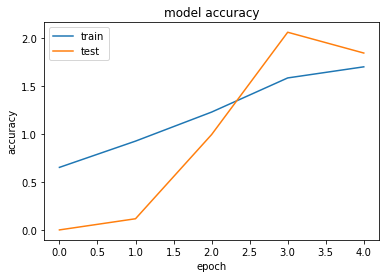

In [69]:
import matplotlib.pyplot as plt
import numpy as np
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

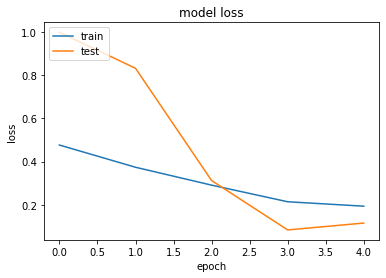

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Make a test set prediction

In [71]:
# Make a prediction

# initialize the test generator
test_gen = test_generator(batch_size=1)

model.load_weights('model.h5')
predictions = model.predict_generator(test_gen, 
                                      steps=len(df_test),  
                                      verbose=1)

/var/folders/p5/lmk0pc4s3njd9swsm4rh_lvr0000gn/T/ipykernel_50691/654260468.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen,
2023-05-05 17:18:34.924034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 8s 273ms/step


In [72]:
!ls

CTBRAIN                                df_val.csv.gz
bone_image_dir                         history.txt
brain_image_dir                        intracranial-hemorrhage-analyzer.ipynb
df_data.csv.gz                         mask_dir
df_test.csv.gz                         model.h5
df_train.csv.gz


### Threshold the predictions

The predictions are actually probabilities that a pixel is either part of a lung or part of the background. Here we threshold the predictions to convert all values to either 0 or 1.

We will use a threshold of 0.7. I got this number by trial and error - try a threshold value and look at the quality of the test set segmentations. 

In [73]:
preds_test_thresh = (predictions >= 0.7).astype(np.uint8)

preds_test_thresh.shape

print(preds_test_thresh.min())
print(preds_test_thresh.max())

0
1


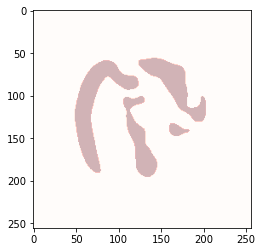

In [74]:
# This is a predicted mask

mask = preds_test_thresh[3,:,:,0]
plt.imshow(mask, cmap='Reds', alpha=0.3)

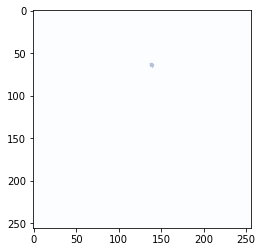

In [75]:
# This is a true mask

true_mask = Y_test[3,:,:,0]
plt.imshow(true_mask, cmap='Blues', alpha=0.3)

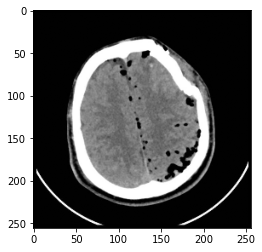

In [76]:
# This is the x-ray image

image = X_test[3,:,:,:]

plt.imshow(image)

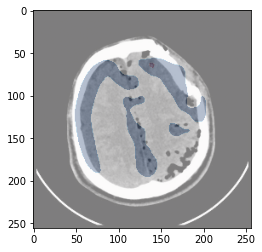

In [77]:
# This is an overlay of the pred mask, true mask and 
# the x-ray image.

plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)

## Overlay pred masks, true masks and the x-ray image

Red - True Mask<br>
Blue - Pred Mask

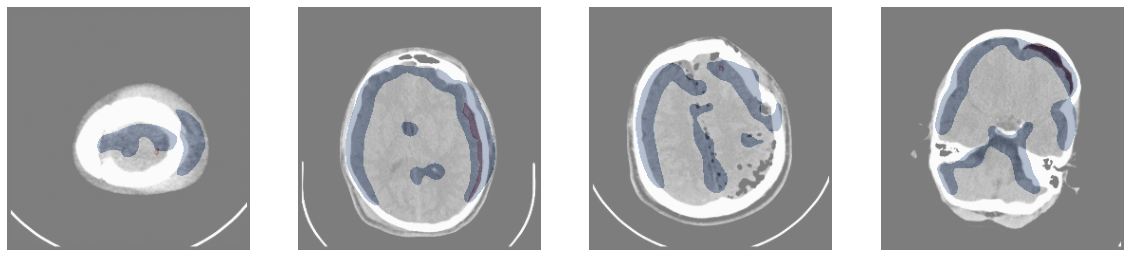

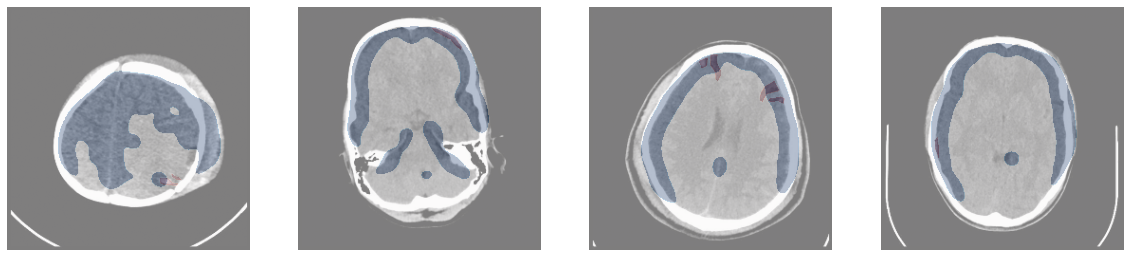

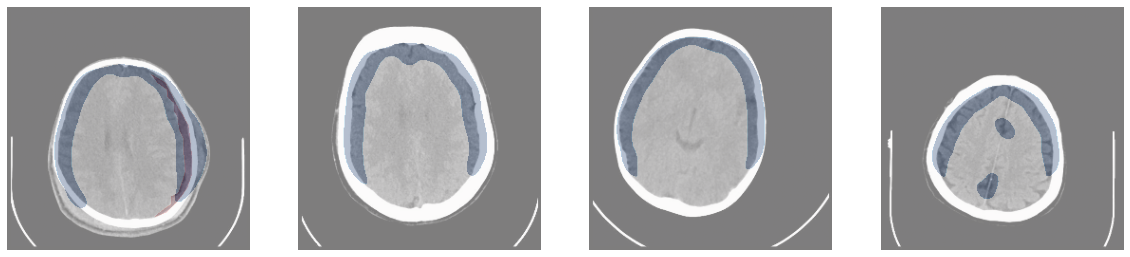

In [78]:
# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')

predicted_masks = preds_test_thresh


count = 1
# image
plt.subplot(1,4,1)
image = X_test[1,:,:,:] 
mask = predicted_masks[1, :, :, 0]
true_mask = Y_test[1, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.savefig(str(count)+'.jpg')
count+=1
plt.axis('off')


# image
plt.subplot(1,4,2)
image = X_test[2,:,:,:] 
mask = predicted_masks[2, :, :, 0]
true_mask = Y_test[2, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.savefig(str(count)+'.jpg')
count+=1
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test[3,:,:,:]
mask = predicted_masks[3, :, :, 0]
true_mask = Y_test[3, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.savefig(str(count)+'.jpg')
count+=1
plt.axis('off')


# image
plt.subplot(1,4,4)
image = X_test[4,:,:,:] 
mask = predicted_masks[4, :, :, 0]
true_mask = Y_test[4, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.savefig(str(count)+'.jpg')
count+=1
plt.axis('off')



# ============ #


# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')


# image
plt.subplot(1,4,1)
image = X_test[5,:,:,:] 
mask = predicted_masks[5, :, :, 0]
true_mask = Y_test[5, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.savefig(str(count)+'.jpg')
count+=1
plt.axis('off')


# image
plt.subplot(1,4,2)
image = X_test[6,:,:,:] 
mask = predicted_masks[6, :, :, 0]
true_mask = Y_test[6, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.savefig(str(count)+'.jpg')
count+=1
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test[7,:,:,:] 
mask = predicted_masks[7, :, :, 0]
true_mask = Y_test[7, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.savefig(str(count)+'.jpg')
count+=1
plt.axis('off')


# image
plt.subplot(1,4,4)
image = X_test[8,:,:,:] 
mask = predicted_masks[8, :, :, 0]
true_mask = Y_test[8, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.savefig(str(count)+'.jpg')
count+=1
plt.axis('off')


# ============ #


# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')


# image
plt.subplot(1,4,1)
image = X_test[9,:,:,:] 
mask = predicted_masks[9, :, :, 0]
true_mask = Y_test[9, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.savefig(str(count)+'.jpg')
count+=1
plt.axis('off')


# image
plt.subplot(1,4,2)
image = X_test[10,:,:,:] 
mask = predicted_masks[10, :, :, 0]
true_mask = Y_test[10, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.savefig(str(count)+'.jpg')
count+=1
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test[11,:,:,:] 
mask = predicted_masks[11, :, :, 0]
true_mask = Y_test[11, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.savefig(str(count)+'.jpg')
count+=1
plt.axis('off')


# image
plt.subplot(1,4,4)
image = X_test[12,:,:,:] 
mask = predicted_masks[12, :, :, 0]
true_mask = Y_test[12, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.savefig(str(count)+'.jpg')
count+=1
plt.axis('off')


plt.show()

## More Architectures to try...

These are three other architectures that I experimented with. They also produced good results in google colab. 

> ### - Segmentation using efficientnet

In [86]:
# Segmentation only
# Encoder: efficientnetb0 
# Decoder: Unet


BACKBONE = 'efficientnetb0'
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
model = Unet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
             #freeze_encoder=False,
             classes=1, 
             encoder_weights='imagenet',
             activation='sigmoid')

#model.summary()
model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [87]:
history= model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=2, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

/var/folders/p5/lmk0pc4s3njd9swsm4rh_lvr0000gn/T/ipykernel_50691/2389460107.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history= model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=2,


Epoch 1/2


2023-05-05 23:46:32.617913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


211/211 [==============================] - ETA: 0s - loss: -5.7706 - binary_accuracy: 0.9039

2023-05-06 00:16:35.997275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss did not improve from -1070.91943
211/211 [==============================] - 1878s 9s/step - loss: -5.7706 - binary_accuracy: 0.9039 - val_loss: -5.2039 - val_binary_accuracy: 0.7876
Epoch 2/2
211/211 [==============================] - ETA: 0s - loss: -33.4829 - binary_accuracy: 0.9311
Epoch 2: val_loss did not improve from -1070.91943
211/211 [==============================] - 1879s 9s/step - loss: -33.4829 - binary_accuracy: 0.9311 - val_loss: -22.5361 - val_binary_accuracy: 0.9906


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


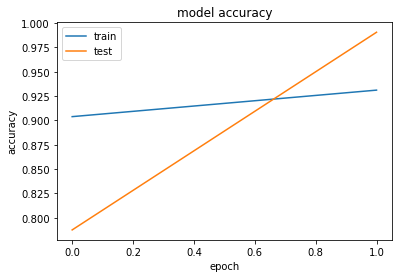

In [88]:
import matplotlib.pyplot as plt
import numpy as np
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

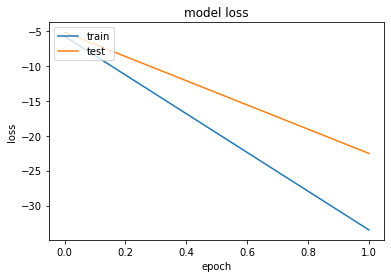

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

> ### - Segmentation and Classification combined

These models output both an image segmentation and an image binary classification (classifies whether intracranial hemorrhage is present or not).

In [90]:
# Segmentation and Binary Classification
# Encoder: efficientnetb0 
# Decoder: Unet


from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)


BACKBONE = 'efficientnetb0'
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
model = Unet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
             #freeze_encoder=False,
             classes=1, 
             encoder_weights='imagenet',
             activation='sigmoid')


# classif path
x = GlobalAveragePooling2D()(model.layers[266].output)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
classif_output = Dense(1, activation='sigmoid', name='classif_output')(x)


my_model1 = Model(inputs=[model.input], outputs=[model.output, classif_output])



#my_model.summary()
my_model1.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [91]:
history= my_model1.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=5, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

Epoch 1/5


/var/folders/p5/lmk0pc4s3njd9swsm4rh_lvr0000gn/T/ipykernel_50691/1095112986.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history= my_model1.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=5,
2023-05-06 00:49:47.660136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


ValueError: in user code:

    File "/Users/aashisrout/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/aashisrout/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/aashisrout/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/aashisrout/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/aashisrout/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/Users/aashisrout/opt/anaconda3/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/aashisrout/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/aashisrout/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/aashisrout/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 2156, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/aashisrout/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py", line 5707, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1) vs (None, None, None, None)).


In [ ]:
# Segmentation and Binary Classification
# Encoder: densenet121 
# Decoder: Unet

from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)

BACKBONE = 'densenet121'
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
model = Unet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
             #freeze_encoder=False,
             classes=1, 
             encoder_weights='imagenet',
             activation='sigmoid')


# classif path
x = GlobalAveragePooling2D()(model.layers[266].output) #layer 197 Resnet34, 266 for efficientnetb0
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
classif_output = Dense(1, activation='sigmoid', name='classif_output')(x)


my_model = Model(inputs=[model.input], outputs=[model.output, classif_output])

#my_model.summary()

## Helpful Resources

- CT Scan Basics<br>
https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109335

- Kaggle RSNA Intracranial Hemorrhage Detection Competition<br>
https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/overview


- segmentation_models package by Pavel Yakubovskiy <br>
https://github.com/qubvel/segmentation_models

- Write up on segmentation models package by Chris Deotte<br>
https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/103367


- Albumentations paper:<br>
Albumentations: fast and flexible image augmentations<br>
https://arxiv.org/abs/1809.06839

- If you would like to learn how to build apps like this I recommend this video tutorial:<br>
https://www.youtube.com/watch?v=HEQDRWMK6yY


- I've also included a few practical tips on the readme page in this repo:<br>
https://github.com/vbookshelf/Skin-Lesion-Analyzer

